In [6]:
import numpy as np
import matplotlib.pylab as plt
import sys,os

# 神经网络的学习
* 本章将介绍神经网络的学习，即利用数据决定参数值的方法
* 用Python实现对MNIST手写数字数据集的学习

# 从数据中学习
如果让我们自己来设计一个能将5正确分类的程序，就会意外地发现这是一个很难的问题。
一种方案是，先从图像中提取特征量，再用机器学习技术学习这些特征量的模式。
* 特征量是指从输入数据（输入图像）中准确地提取本质数据（重要的数据）的转换器

两种针对机器学习任务的方法，如下图所示
## 第一种需要人为干涉
## 第二种不需要人为干涉

![两种针对机器学习任务的方法](img\img4_1.png " ")

# 均方误差（mean squared error）
均方误差会计算神经网络的输出和正确解监督数据的各个元素之差的平方,再求总和
![均方误差](img\img4_2.png " ")

In [1]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [7]:
# 设“2”为正确解
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t))

0.09750000000000003

# 交叉熵误差（cross entropy error）
交叉熵误差的值是由正确解标签所对应的输出结果决定的
![交叉熵误差](img\img4_3.png " ")

In [2]:
def cross_entropy_error(y, t):
    delta = 1e-7 # 当出现np.log(0)时，np.log(0)会变为负无限大的-inf
                # 作为保护性对策，添加一个微小值可以防止负无限大的发生
    return -np.sum(t * np.log(y + delta))

In [6]:
# 设“2”为正确解
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

    均方误差和交叉熵误差是两种不同的损失函数，损失函数是表示神经网络性能的“恶劣程度”的指标，即当前的神经网络对监督数据在多大程度上不拟合。

# mini-batch学习
从训练数据中选出一批数据（称为mini-batch,小批量），然后对每个mini-batch进行学习。

## 批数据的损失函数
以交叉熵误差为例：
![交叉熵误差对于批数据的损失函数](img\img4_4.png " ")

# 数值微分
数值微分就是求导

In [19]:
#求一个函数的导数
def numerical_diff(f , x):
    h = 1e-4 #0.0001
    return (f(x+h) - f(x-h)) / (2*h)
#这里使用的方法是导数的定义

例子，求一个二次函数的导数，如下：
![二次函数](img\img4_5.png " ")

In [20]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

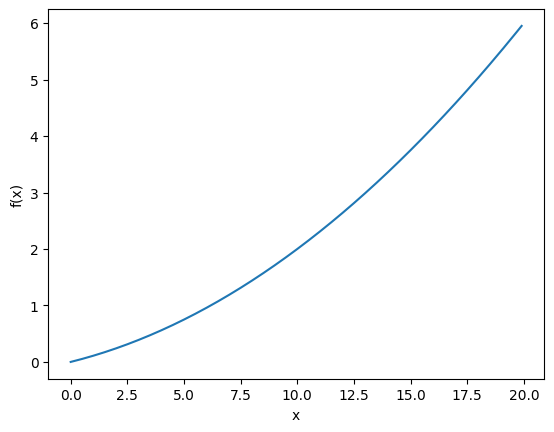

In [21]:
#画出这个函数图像
x = np.arange(0.0, 20.0, 0.1) # 以0.1为单位，从0到20的数组x
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [22]:
#计算一下这个函数在x = 5处的导数
numerical_diff(function_1, 5)

0.1999999999990898

## 偏导数
求偏导数时可以将其中一项固定，把原函数转化为只有一个自变量，然后对这个自变量正常求导即可。

## 梯度（gradient）
由全部变量的偏导数汇总而成的向量称为梯度（gradient）。
* 梯度就是一次求出所有的偏导数，然后把它们用一个向量组表示

梯度的实现：

In [5]:
def numerical_gradient(f ,x):
    h = 1e-4
    grad = np.zeros_like(x) #默认x为numpy数组，这个函数可以生成一个与x形状一样，元素全为0的数组
    for idx in range(x.size):
        tmp_val= x[idx] #把x值保存下来
        #f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        #f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2)/(2*h)
        x[idx]=tmp_val # 还原x的值
    return grad
# 这样就一次求了两个自变量的偏导数并且返回一个数组

In [6]:
#给出一个函数，检查梯度的计算有没有出错
#此处的函数是f(x0 + x1)=x0**2 + x1**2
def function_2(x):
    return x[0]**2 + x[1]**2
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

![梯度的解释](img\img4_51.png " ")

虽然图 4-9 中的梯度指向了最低处，但并非任何时候都这样。实际上，
梯度会指向各点处的函数值降低的方向。更严格地讲，梯度指示的方向
是**各点处的函数值减小最多的方向** .

# 梯度法
* 目的：求出损失函数最小值。因为损失函数很复杂，参数空间庞大，我们不知道它在何处能取得最小值。而通过巧妙地使用梯度来寻找函数最小值（或者尽可能小的值）的方法就是梯度法。
* 方法：在梯度法中，函数的取值从当前位置沿着梯度方向前进一定距离，然后在新的地方重新求梯度，再沿着新梯度方向前进，如此反复，不断地沿梯度方向前进。

**这里需要注意的是，梯度表示的是各点处的函数值减小最多的方向。** 因此，
无法保证梯度所指的方向就是函数的最小值或者真正应该前进的方向。实际
上，在复杂的函数中，梯度指示的方向基本上都不是函数值最小处。
![数学式表示梯度法](img\img4_6.png " ")

η表示更新量，在神经网络的学习中，称为学习率（learning rate）。

学习率需要事先确定为某个值，比如0.01或0.001。一般而言，这个值过大或过小，都无法抵达一个“好的位置”

In [7]:
#这是梯度法的简单python实现
# f-函数  init_x-初始x值  lr-学习率  step_num-循环的次数
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x) #每次都求一个新的梯度
        x -= lr * grad #沿着新的梯度前进
    return x

上面这个函数就可以求函数的极小值，顺利的话还可以求最小值。

现在解决下面的这个问题

求`f(x0 + x1)=x0**2 + x1**2`的最小值

In [8]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([8.0,9.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)
#真实的最小值就是(0,0)，求出来的值也非常接近它

array([1.62962878e-09, 1.83333238e-09])

下面，我们以一个简单的神经网络为例，来实现求梯度的代码。

该神经网络的权重是2 X 3

In [9]:
#实现求梯度的代码
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 用高斯分布进行初始化
    
    def predict(self, x): #用于预测 
        return np.dot(x, self.W)
    
    def loss(self,x,t): #用于求损失函数
        z = self.predict(x)#x接收输入数据
        y = softmax(z)
        loss = cross_entropy_error(y,t)#t接收正确解标签
        return loss

In [10]:
#用一下这个simplenet
net = simpleNet()
print(net.W)

[[-0.18543619  0.46651284 -0.02628108]
 [ 0.64824882 -0.77673585  0.56865545]]


In [11]:
x = np.array([0.6 , 0.9])
p = net.predict(x)
print(p)

[ 0.47216222 -0.41915456  0.49602125]


In [14]:
np.argmax(p)#最大值的索引

t = np.array([0, 0, 1]) # 正确解标签
net.loss(x, t)

0.8657840727376378

## 接下来求梯度

唉我都不想记了，记在笔记本上咯

## 流程以外的东西

**lambda表示法**：Lambda表示法是一种函数定义的方式，它是一种匿名函数，即没有函数名的函数定义。

在lambda表示法中，函数定义以lambda关键字开头，后面跟着参数列表和函数体，用冒号隔开

比方说：

`lambda arguments: expression `

其中，arguments表示参数列表，可以是一个或多个参数，用逗号隔开；expression表示函数体，是一个表达式，可以是任何可求值的Python表达式。

例如，下面的代码定义了一个lambda函数，用于计算两个数的和：

`add = lambda x, y: x + y`

这个lambda函数可以通过add(2, 3)的方式调用，返回结果为5

# 大的要来啦---两层神经网络的类的实现
先把代码粘出来

In [17]:
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        return y
    
    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

    #这些内容在书本pdf第138页，建议常常复习

## 首先是__init__(self, input_size, hidden_size, output_size, weight_init_std=0.01)

* 进行了一些初始化的设定
* 形参列表依次为self，输入层神经元个数，隐藏层神经元个数，输出层神经元个数，步长
* 解释一下w：在这个例子中，权重矩阵W1和W2的初始值是从标准正态分布中随机生成的，并且乘以了一个小的标量weight_init_std，以缩小它们的值域。这样做是为了确保权重矩阵的初始值不会过大或过小，从而避免出现梯度消失或爆炸的情况。
* 解释一下b：而偏置向量b1和b2的初始值设置为全零向量，是因为在神经网络中，偏置的作用是将神经元的激活值平移一定量，使得神经元可以更好地适应数据。因此，偏置项的初始值通常设置为零，可以让神经元的激活值在开始时偏向正值或负值，从而增强了神经元的表达能力。

## 其次是predict(self, x)

* 这是一个预测函数

* w1 w2,b1 b2分别是第一层和第二层的权重和偏置

* 输入层到隐藏层之间使用向量组的点乘，然后加上偏置

* 隐藏层的内部使用**sigmoid函数**当作激活函数

* 隐藏层再与它的权重点乘，再加上偏置得到输出层的初始值

* 输出层使用**softmax函数**当作激活函数，将初始的数值转化为概率的分布

* **softmax函数**和**sigmoid函数**的区别在于：在二分类问题中，**sigmoid函数**通常作为输出层激活函数使用；在多分类问题中，**softmax函数**通常作为输出层激活函数使用，将网络的输出转换为各个类别的概率分布

## 然后是loss(self, x, t)

* 这个方法的作用就是计算当前的x和t的损失函数值是多少
* 思路是：先通过预测函数预测出结果，再通过预测与真正结果的交叉熵得到数值

## 然后是accuracy(self, x, t)

* 这个函数的作用是计算预测成功的概率
* 思路是：我先预测出结果，然后用正确的解标签数目/总数目，得到一个概率

## 然后是numerical_gradient(self, x, t)

* 这个函数用来计算当前损失函数(在自变量为W时)的偏导数
* 使用数值微分法计算，简单粗暴
* 这里用了**函数重载**
* 别看函数体里有numerical_gradient()，但是和它自己的形参列表不同
* 函数体里的那个numerical_gradient()是import进来的另外的函数

~~我真是个蠢货一开始还以为是递归我说我怎么哪哪看不懂还以为自己脑子坏了~~

## 最后是gradient(self, x, t)
* 这个函数还没搞懂，已知使用了另一种方法求梯度(偏导数)

# mini-batch的实现

In [ ]:
from dataset.mnist import load_mnist
from other.two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) =load_mnist(normalize=True, one_hot_label = True)
# x_train的形状是(60000,784)

train_loss_list = [] #训练函数的损失函数值列表，盲猜一会儿会生成这个列表的图像

# 超参数
iters_num = 10000 #循环次数
train_size = x_train.shape[0] #train_size是60000，int型
batch_size = 100 #批大小
learning_rate = 0.1 #步长

#网络初始化
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)#这是从训练数据中随机抽出一批次数据的写法
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]#这两步挑选出了需要的数据
    
    #计算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
    
    #更新参数
    #这里就真正凸显出SGD了
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)#这里使用append方法记录函数值到列表里，前面猜对了
    

小小科普！

np.random.choice函数是NumPy库中用于从给定数组中随机抽取元素的函数。它的语法如下：

`numpy.random.choice(a, size=None, replace=True, p=None)`

参数说明：

a：要从中抽取元素的数组，可以是一维数组或整数。

size：抽取的样本数量，默认为1。如果为整数，则返回抽取元素的一维数组；如果为元组，则返回抽取元素的多维数组。

replace：是否可以重复抽取同一个元素，取值为True或False，默认为True。

p：数组中每个元素被抽取的概率，可以是一维数组或标量。如果不指定，则默认为每个元素被抽取的概率相等。

## 以下是更加先进的两层神经网络的学习过程

In [ ]:
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_laobel = True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 平均每个epoch的重复次数。就是整个训练数据的重复次数
iter_per_epoch = max(train_size / batch_size, 1)

# 超参数
iters_num = 10000
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 获取mini-batch。随机抽出一批数据
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版!
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        # 计算每个epoch的识别精度
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)#训练数据的识别精度
            test_acc = network.accuracy(x_test, t_test)#测试数据的识别精度
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

第一步：从数据集中提取数据

第二步：设定列表来记录每次训练完成之后各个参数的结果

第三步：设定超参数

第四步：构建神经网络

第五步：进入循环；抽取第一批数据

第六步：计算梯度

第七步：向着梯度下降的方向，更新参数

第八步：将损失函数值存入损失训练函数列表中

第九步：计算训练数据的识别精度和测试数据的识别精度，然后分别存入列表中